# Representing geographic data in raster format

Raster data consists of rows and columns of cells or pixels, with each cell representing a single value. This type of data is often thought of as images, although raster datasets can be stored in various formats such as **ASCII text files** or **Binary Large Objects (BLOBs)** within databases.

![Raster Data Representation](static/raster_rep.png)

*Image Source: [ESRI - What is Raster Data](https://desktop.arcgis.com/en/arcmap/latest/manage-data/raster-and-images/what-is-raster-data.htm)*


#### Key Characteristics of Raster Data:
- **Resolution**: Resolution refers to the ground distance that each cell represents. For example, if the resolution is two meterst, each cell corresponds to an area two meters by two meters. A raster dataset with higher resolution can show more detail, but it will also have larger file sizes.
- **Multiple Bands**: Raster datasets can contain multiple bands, meaning that different wavelengths of light or other data can be collected simultaneously over the same area. For example, satellite images may have bands representing the Red, Green, and Blue (RGB) spectrum. 

  
#### Formats for Raster Data#### Raster data analysis with Python
Raster data can be stored in a variety of formats, some of the more common ones include:
- **TIFF (Tagged Image File Format)**: This is the most common geospatial raster format due to its flexibility. It allows for storage of multiple bands, metadata, and internal compression. However, TIFF files can sometimes be incompatible across software.
- **JPEG, GIF, BMP, PNG**: These formats are more suitable for images used in presentations or online applications. While common, they are not as robust for storing geospatial data due to lack of metadata support.
- **ASCII Grid**: This format is often used for storing elevation data as simple text files, with spatial information stored in a header.

## Raster data analysis with Python

This lesson will guide you through performing raster GIS analysis using modern Python libraries. You'll learn how to read, manipulate, analyze, and visualize raster data using `xarray`, `rioxarray`, and `xarray-spatial`. In this part of our raster lesson, we will learn how to:

- Import and read raster data in Python
- Visualize raster data
- Merge multiple raster files together and create a `raster mosaic`
- Clip raster using a polygon
- Reclassify raster
- Perform `Slope` analysis


In [1]:
# xarray rioxarray xarray-spatial matplotlib geopandas owslib

### Loading raster data

For this part of lesson, we will use the elevation model data provided from [National Land Survey of Finland](https://www.maanmittauslaitos.fi/en/maps-and-spatial-data/datasets-and-interfaces/product-descriptions/elevation-model-2-m). 4 raster tiles (L4133A, L4133B, L4133C,L4133D) covering parts of Helsinki city center are already downloaded and will be used in this lesson. 

But before we get started let's take a quick look at an example of how we can retrieve raster files or map images via  **Web Map Service (WMS)**. WMS is a standard protocol developed by the **Open Geospatial Consortium (OGC)** that allows users to request and retrieve georeferenced map images over the internet. WMS provides maps in common image formats (such as PNG, JPEG, and GeoTIFF). It is widely used in GIS applications, and is a common method for organizations (such as city of Helsinki in our example) to share their Raster data. In th example below, we fetch a base map of Helsinki from [avoindata.fi](https://www.avoindata.fi/data/en_GB/dataset/helsingin-kantakartta/resource/070e6c10-1cf8-4e4e-8caa-2beddf6814f5?view_id=ce27e198-ff71-4829-b0c8-b9c88b2c4acd) and read and viusalize it using `Rasterio` library.

Layer: avoindata:Kantakartta - Kantakartta
Layer: avoindata:Kantakartta_harmaa - Kantakartta_harmaa
Layer: avoindata:Kantakartta_varillinen - Kantakartta_varillinen
More layers available...


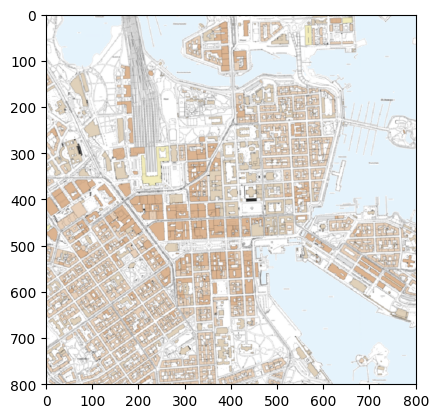

In [21]:
import requests
from owslib.wms import WebMapService
from io import BytesIO
import rasterio
from rasterio.plot import show

# WMS URL from Helsingin kantakartta dataset
wms_url = "https://kartta.hel.fi/ws/geoserver/avoindata/wms"

# Connect to the WMS service
wms = WebMapService(wms_url, version="1.3.0")

# List available layers (Only print the first 3 to avoide clutter)
for i, (layer_name, layer) in enumerate(wms.contents.items()):
    if i < 3:
        print(f"Layer: {layer_name} - {layer.title}")
    else:
        print("More layers available...")
        break

# Define the layer and bounding box (for Helsinki region)
layer_name = "avoindata:Kantakartta"
bbox = (24.93, 60.16, 24.97, 60.18)  # Example bounding box in EPSG:4326 (longitude, latitude)

# Define the GetMap request parameters
wms_request_url = wms.getmap(
    layers=[layer_name],
    srs='EPSG:4326',  # Coordinate system (WGS84)
    bbox=bbox,        # Bounding box for Helsinki area
    size=(800, 800),  # Image size in pixels
    format='image/png',  # Request PNG image format
    transparent=True
)

# Extract the actual URL from the ResponseWrapper
url = wms_request_url.geturl()  # This extracts the URL string

# Fetch the map from the WMS as a PNG image
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Load the image into rasterio
    with rasterio.open(BytesIO(response.content)) as src:
        # Plot the map image
        show(src)
else:
    print(f"Failed to retrieve WMS data. Status code: {response.status_code}")


Now that we saw how we can retrieve map images using WMS, let's get started with our actual work with the elevation data. For this lesson we are using [`rioxarray`](https://corteva.github.io/rioxarray/stable/) which is a more modern library for handling raster data in Python. Let's start by importing our data. We start with one tile first:

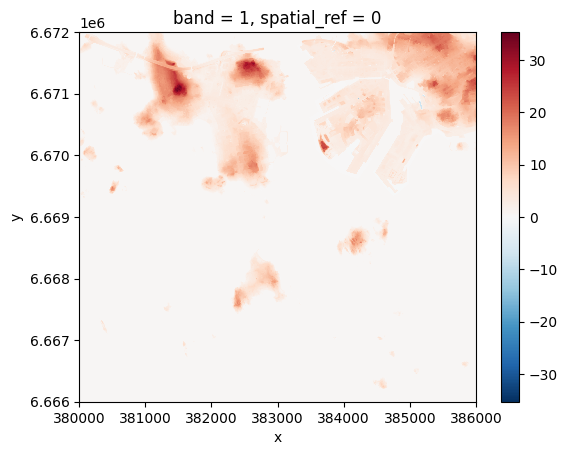

In [22]:
import rioxarray

# Load the raster file
raster_path = 'data/L4133A.tif'
raster = rioxarray.open_rasterio(raster_path)

# Plot the raster data
raster.plot()

You can easily print the basic raster meta data using `print` function.

In [23]:
print(raster)

<xarray.DataArray (band: 1, y: 3000, x: 3000)> Size: 36MB
[9000000 values with dtype=float32]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 24kB 3.8e+05 3.8e+05 3.8e+05 ... 3.86e+05 3.86e+05
  * y            (y) float64 24kB 6.672e+06 6.672e+06 ... 6.666e+06 6.666e+06
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999.0
    scale_factor:   1.0
    add_offset:     0.0


And to check the CRS:

In [3]:
raster.rio.crs

CRS.from_epsg(3067)

Now let's import all four raster files and visualize them together. 

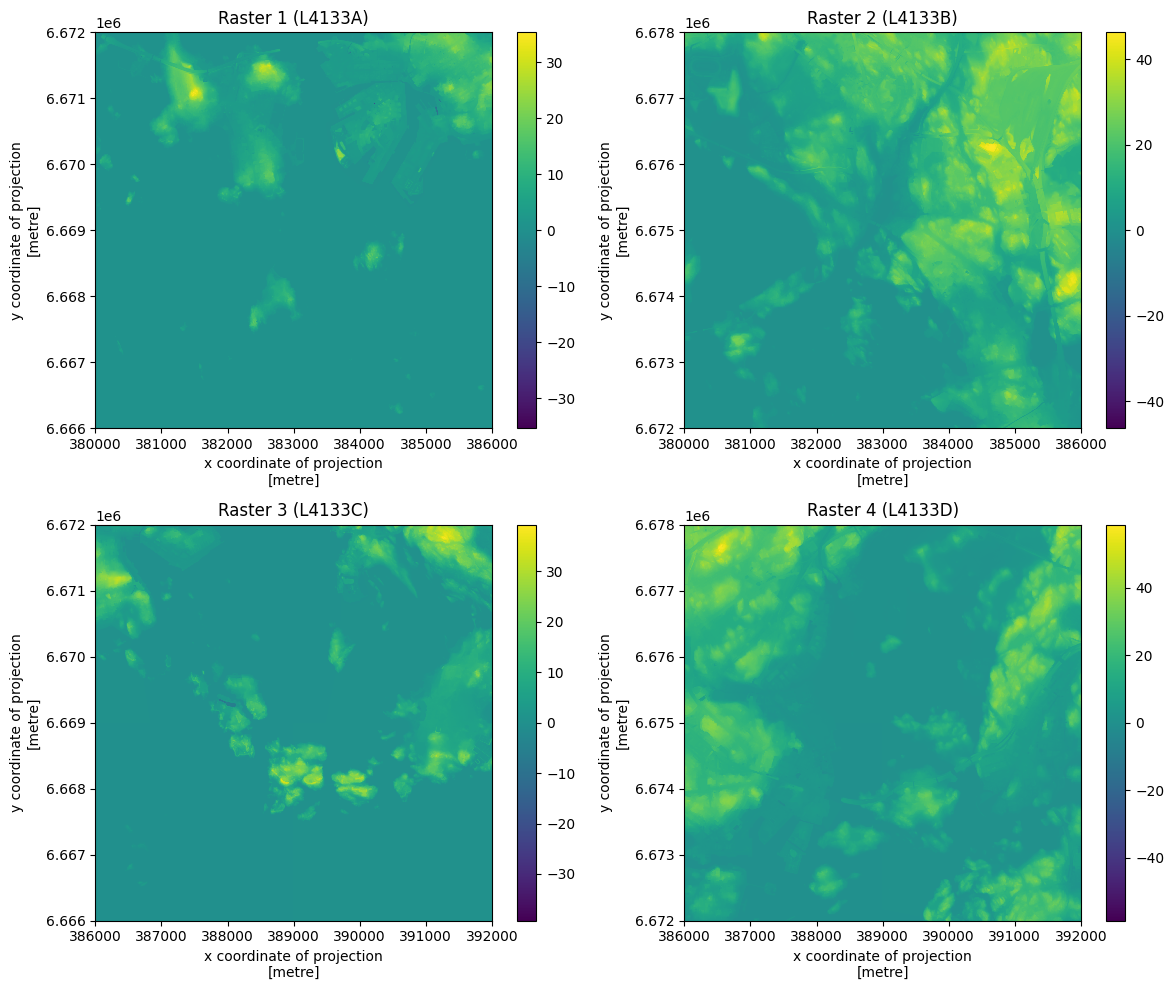

In [24]:
import rioxarray
import matplotlib.pyplot as plt

# Load the rasters and reproject them to EPSG:3067
raster1 = rioxarray.open_rasterio('data/L4133A.tif').rio.reproject("EPSG:3067")
raster2 = rioxarray.open_rasterio('data/L4133B.tif').rio.reproject("EPSG:3067")
raster3 = rioxarray.open_rasterio('data/L4133C.tif').rio.reproject("EPSG:3067")
raster4 = rioxarray.open_rasterio('data/L4133D.tif').rio.reproject("EPSG:3067")

# Create a subplot with 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot each raster in a separate subplot
raster1.plot(ax=axes[0, 0], cmap='viridis')
axes[0, 0].set_title('Raster 1 (L4133A)')

raster2.plot(ax=axes[0, 1], cmap='viridis')
axes[0, 1].set_title('Raster 2 (L4133B)')

raster3.plot(ax=axes[1, 0], cmap='viridis')
axes[1, 0].set_title('Raster 3 (L4133C)')

raster4.plot(ax=axes[1, 1], cmap='viridis')
axes[1, 1].set_title('Raster 4 (L4133D)')

# Adjust layout
plt.tight_layout()
plt.show()


### Create raster mosaic 

Raster files are usualy large in size, therefor it is quite common for providers to publish them in smaller pieces or tiles. While this makes it easier to transfer the data, it may not be so practical when it comes to the actual analysis. For example, as seen above, the elevation model from center of Helsinki is divided into 4 separate raster files. Now we want to merge multiple raster files together and create a raster mosaic. This can be done easily with the `merge_arrays()` -function in `rioxarray`.

In our case, the raster files are coming from the same source, and are actually pieces of a larger data. If that was not the case, it would have been a good idea to start by aligning our raster tiles, ensuring that they can be seamlessly combined. The `Align` function helps align your raster files in terms of resolution, projection, and spatial extent.

```
import xarray as xr
# Ensure all rasters have the same CRS
assert raster1.rio.crs == raster2.rio.crs == raster3.rio.crs == raster4.rio.crs, "Rasters have different CRS"

# Align the rasters to the same resolution and spatial extent
raster1, raster2 = xr.align(raster1, raster2)
raster3, raster4 = xr.align(raster3, raster4)
```

Now let's merge our data:

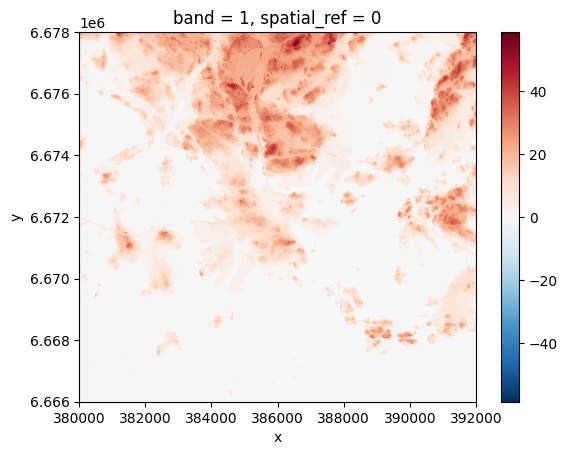

In [33]:
from rioxarray.merge import merge_arrays

# Merge the rasters into one
mosaic_merged = merge_arrays([raster1, raster2, raster3, raster4])

# Save the merged raster (optional)
# mosaic_merged.rio.to_raster('merged_raster.tif')

# Plot the mosaic raster
mosaic_merged.plot()

### Clipping raster using a polygon

Clipping a raster using vector data (i.e., a polygon) is another common operation with raster data. In this part of lesson, we use wfs to get the administrative boundaries in Helsinki area. 

In [30]:
from owslib.wfs import WebFeatureService
import geopandas as gpd

# Define the bounding box for Helsinki (EPSG:3879)
bbox_helsinki = "25400000,6670000,25500000,6680000"

# Fetch the Paavo data limited to the Helsinki area using WFS
paavo_data_helsinki = gpd.read_file(
    "https://geo.stat.fi/geoserver/wfs"
    "?service=wfs"
    "&version=2.0.0"
    "&request=GetFeature"
    "&typeName=postialue:pno"  # Adjust to the correct layer if needed
    "&srsName=EPSG:3879"
    f"&bbox={bbox_helsinki},EPSG:3879"
)

# Display the first few rows of the data
paavo_data_helsinki.head()

# Save to a file if needed
# paavo_data_helsinki.to_file("paavo_data_helsinki.geojson", driver="GeoJSON")


,gml_id,objectid,posti_alue,vuosi,nimi,namn,kunta,kuntanro,pinta_ala,geometry
0,pno.1,1,00100,2024,Helsinki keskusta - Etu-Töölö,Helsingfors centrum - Främre Tölö,091,91,2353278,"POLYGON ((25496638.898 6672477.679, 25496762.1..."
1,pno.2,2,00120,2024,Punavuori - Bulevardi,Rödbergen - Bulevarden,091,91,414010,"POLYGON ((25496316.740 6671953.498, 25496387.6..."
2,pno.3,3,00130,2024,Kaartinkaupunki,Gardesstaden,091,91,428960,"POLYGON ((25497213.040 6671964.915, 25497297.9..."
3,pno.5,5,00150,2024,Punavuori - Eira - Hernesaari,Rödbergen - Eira - Ärtholmen,091,91,1367328,"MULTIPOLYGON (((25495892.616 6670428.430, 2549..."
4,pno.32,32,00420,2024,Kannelmäki,Gamlas,091,91,2890057,"POLYGON ((25493298.180 6682931.149, 25493149.3..."


Now we can use the contents of the column *posti_alue* to select a ppostal area of our choice. Let's try Kamppi; we know that the postal code for Kamppi is `00100`.

<Axes: >

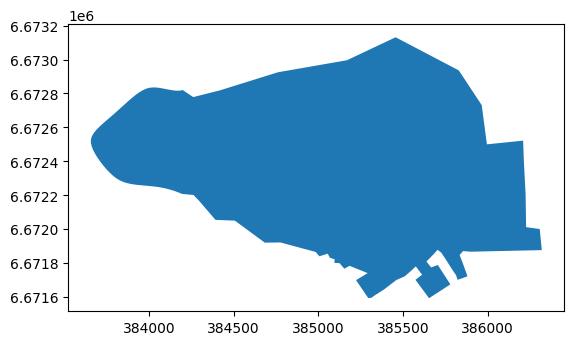

In [34]:
# Select Kamppi polygon based on postal code
kamppi = paavo_data_helsinki[paavo_data_helsinki['posti_alue'] == '00100']

# Transfrom the polygon to the same CRS as our raster data
kamppi = kamppi.to_crs(mosaic_merged.rio.crs)

kamppi.plot()

> **Note:**
> Similar to other map overlay analyses, it is essential to ensure that the CRS (Coordinate Reference System) of the raster files and the clipping feature are matching.

Once again, let's make sure that the CRS are matching and then let's proceed with the clipping. 

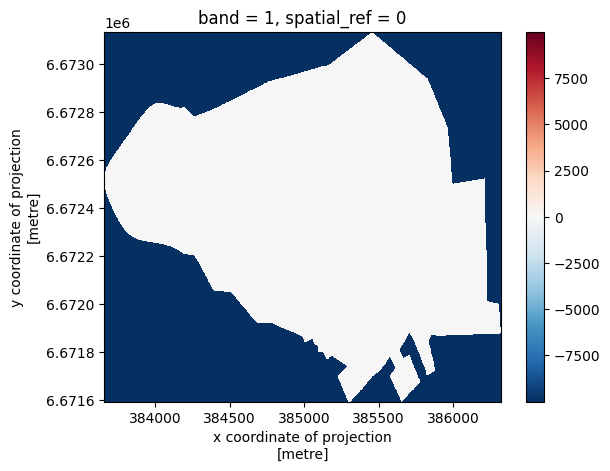

In [48]:
# Double check that the CRS match
assert raster1.rio.crs == kamppi.crs , "CRS Mismatch"

# Clip the raster using the Kamppi polygon
clipped_mosaic = mosaic_merged.rio.clip(kamppi.geometry, kamppi.crs)

# Save the clipped raster (optional)
# clipped_mosaic.rio.to_raster("clipped_mosaic_kamppi.tif")

clipped_mosaic.plot()

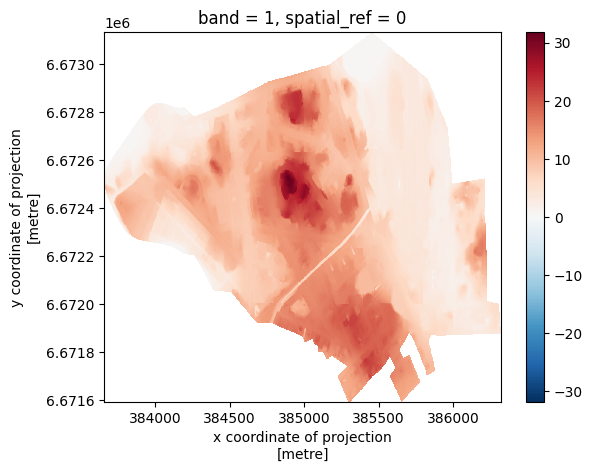

In [49]:
nodata_value = clipped_mosaic.rio.nodata
# Mask the NoData values
clipped_raster = clipped_mosaic.where(clipped_mosaic != nodata_value)
clipped_raster.plot()

## Raster reclassification

**Raster reclassification** is another common procedure with raster dataset. Raster reclassification is the process of assigning new values to the pixels of a raster dataset based on their existing values. This is often used to simplify or categorize continuous data, such as elevation or land cover, into distinct classes. For example, in an elevation map, reclassification can group different elevation ranges into categories like "low", "medium", and "high" altitude, making it easier to analyze or visualize the data for specific applications such as hazard assessment or land management.

let's first have a look at the range of values (altitudes) in our raster data:

In [50]:
# Check the data range
print(clipped_raster.min().values, raster.max().values)

-1.829 35.34


Now we want to reclassify our data using two approaches. First, let's do it manually using the `numpy` library. **[NumPy](https://numpy.org/doc/)** is a powerful Python library used for numerical and scientific computing. It provides support for large, multi-dimensional arrays and matrices, along with a wide collection of mathematical functions to operate on these arrays efficiently. So basically here, we are treating our pixel values as an `Array` and do the calculations accordingly. 

> **Note:**
> An **array** (such as those created by NumPy) is a multi-dimensional container for data, but it lacks metadata like coordinate labels or attributes. In contrast, an **xarray.DataArray** enhances the array by adding labeled dimensions, coordinates, and attributes, making it easier to work with multi-dimensional data, especially in geospatial and time-series contexts.


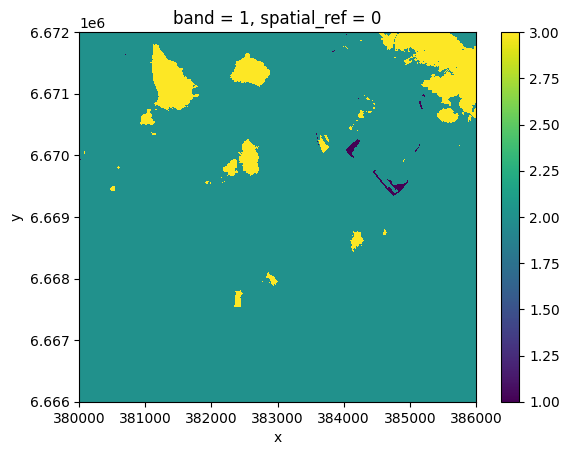

In [59]:
import numpy as np
import xarray as xr

# Define the bins and new class values
# 'bins' specifies the thresholds for reclassification: 
# - Values less than 0 will be classified as "Low"
# - Values between 0 and 10 will be classified as "Mid"
# - Values greater than 10 will be classified as "High"
bins = [-50, 0, 10, np.inf]  # Bins for elevation: <0, 0-10, 10+

# 'new_values' contains the labels or categories corresponding to the bin ranges
new_values = [1, 2, 3]  # Corresponding new class values

# Apply the reclassification
# 'np.digitize' assigns each value in 'raster' to a bin defined in 'bins'
# 'right=True' means each bin includes its right edge, e.g., 0 is in the "Mid" category
# This returns an array where each pixel is assigned a class index (1 for Low, 2 for Mid, etc.)
reclassified_raster = np.digitize(raster, bins, right=True)

# Convert the reclassified array to an xarray.DataArray
# 'dims' preserves the original raster dimensions (e.g., x, y coordinates)
# 'coords' retains the spatial coordinate information from the original raster
# 'attrs' keeps any metadata associated with the raster (e.g., CRS, description)
reclassified_raster = xr.DataArray(
    reclassified_raster,
    dims=raster.dims,  # Keep the same dimensions as the original raster
    coords=raster.coords,  # Retain the spatial coordinates (x, y)
    attrs=raster.attrs  # Preserve the original attributes (e.g., CRS, metadata)
)
reclassified_raster.plot()

> **Note:**
> When using `np.digitize()`, the function returns indices of the bins, starting from `1`. This means the output will not directly contain the desired reclassified values. To map the bin indices to the actual values, you need to create a mapping, such as using a list comprehension to convert the indices into the specified new values. Don't forget to subtract `1` from the indices because Python lists are zero-indexed, while `np.digitize()` starts indexing at `1`.


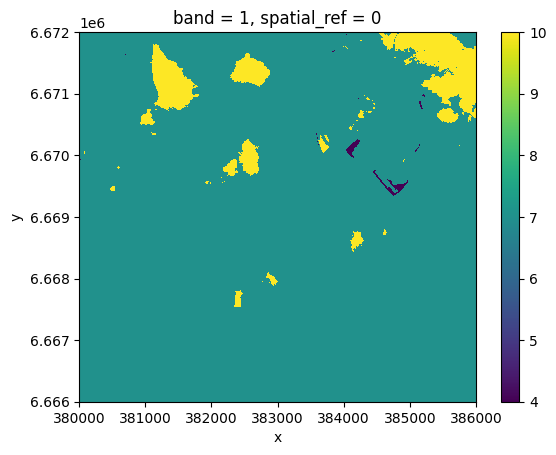

In [65]:
# Define the bins and new class values
bins = [-50, 0, 10, np.inf]  # Bins for elevation: <0, 0-10, 10+
new_values = [4, 7, 10]  # Corresponding new class values

# Apply the reclassification
# 'np.digitize' assigns each value in 'raster' to a bin defined in 'bins'
# This will give indices: 1 for the first bin, 2 for the second bin, etc.
reclassified_indices = np.digitize(raster, bins, right=True)

# Create an empty array with the same shape as the reclassified indices
reclassified_raster = np.empty_like(reclassified_indices, dtype=int)

# Iterate over the array using np.nditer and map the indices to the new values
for idx, value in np.ndenumerate(reclassified_indices):
    reclassified_raster[idx] = new_values[value - 1]  # Map the index to the corresponding class value

# Convert the reclassified array to an xarray.DataArray
reclassified_raster = xr.DataArray(
    reclassified_raster,
    dims=raster.dims, 
    coords=raster.coords,  
    attrs=raster.attrs  
)

# Now reclassified_raster will contain the values 4, 7, and 10 based on the bins.
reclassified_raster.plot()

We can use the `mapclassify` library which we learned about in Lesson 4, to reclassify our raster. Let's Try *NaturalBreaks* method here.  

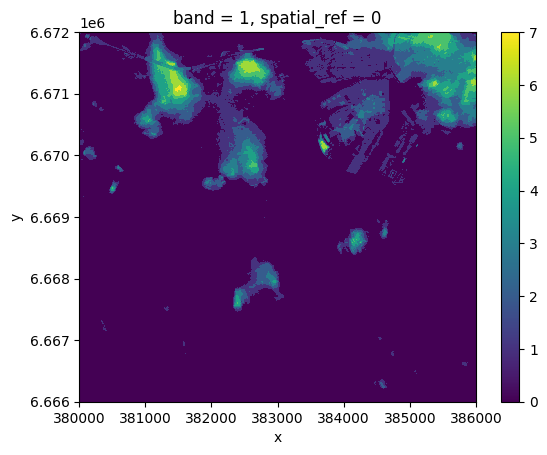

In [67]:
import mapclassify

# Flatten the raster data
raster_data_flattened = clipped_raster.values.flatten()

# Filter out NoData values
raster_data_flattened = raster_data_flattened[~np.isnan(raster_data_flattened)]

# Apply Natural Breaks classification with a specified number of classes (e.g., 5)
natural_breaks = mapclassify.NaturalBreaks(raster_data_flattened, k=7)

# Get the classified bins (breaks)
breaks = natural_breaks.bins

# Use np.digitize to classify the raster values according to the natural breaks
reclassified_raster = np.digitize(raster.values, bins=breaks)


# Convert the reclassified array to DataArray
reclassified_raster_nb = xr.DataArray(
    reclassified_raster,
    dims=raster.dims,
    coords=raster.coords,
    attrs=raster.attrs
)
reclassified_raster_nb.plot()

## Slope analysis

**Slope analysis** is a key terrain analysis technique used in GIS and spatial analysis to measure the steepness or incline of the terrain at any given point. It is calculated by examining the rate of change in elevation between neighboring pixels in a digital elevation model (DEM). Slope analysis helps identify areas with steep gradients, which is useful in applications like land-use planning, erosion risk assessment, hydrological modeling, and infrastructure development. The slope is typically expressed in degrees or as a percentage.

In this lesson, we calculat slope using our clipped elvation raster (before reclassification). The slope at each point is derived by calculating the rate of change in elevation between neighboring cells in the raster. This is done by:

1. **Gradient Calculation**: We use the elevation differences between adjacent cells in both the x (horizontal) and y (vertical) directions. The gradient represents how quickly elevation changes in these directions.
   
2. **Slope Formula**: The slope is calculated by combining these gradients using the Pythagorean theorem:
   \[
   \text{slope} = \sqrt{\left(\frac{\Delta z}{\Delta x}\right)^2 + \left(\frac{\Delta z}{\Delta y}\right)^2}
   \]
   where \( \Delta z \) is the change in elevation, and \( \Delta x \) and \( \Delta y \) are the distances between the cells in the x and y directions.

3. **Final Slope Values**: The result is often expressed in degrees or as a percentage, with steeper areas showing higher slope values. We use degrees here. 


In [68]:
# Get the pixel resolution (assuming square pixels)
xres = clipped_raster.rio.resolution()[0]  # Resolution in x direction (longitude)
yres = clipped_raster.rio.resolution()[1]  # Resolution in y direction (latitude)

# Calculate gradients in the x and y directions
dzdx = clipped_raster.differentiate(coord='x') / xres  # Gradient in the x direction
dzdy = clipped_raster.differentiate(coord='y') / yres  # Gradient in the y direction

# Calculate the slope (in degrees)
slope = np.sqrt(dzdx**2 + dzdy**2)
slope = np.arctan(slope) * (180 / np.pi)

# Update the attributes to reflect that this is a slope raster
slope.attrs['long_name'] = 'Slope'
slope.attrs['units'] = 'degrees'

Now let's plot our Slope raster. 

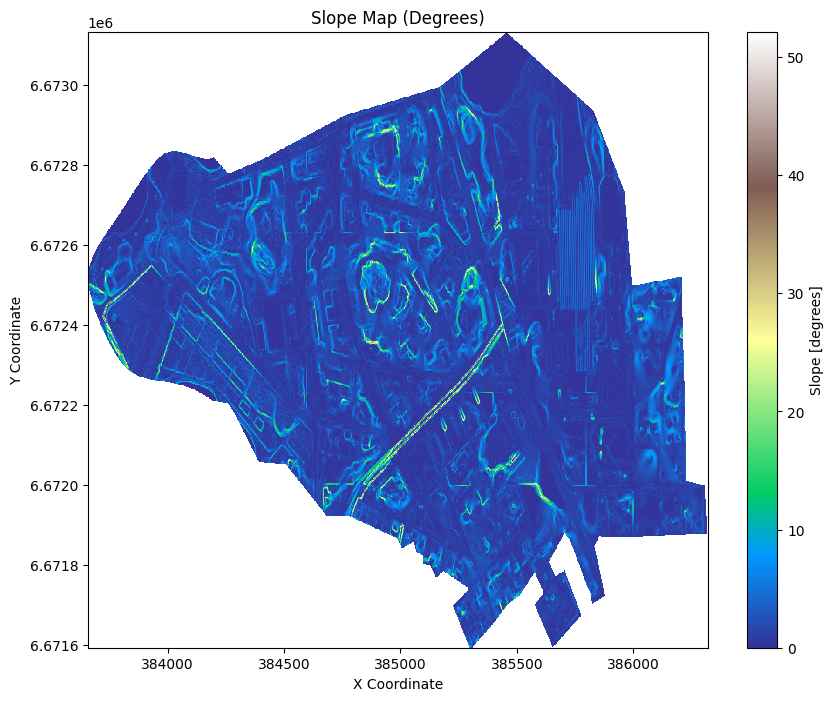

In [70]:
# Plot the slope raster
plt.figure(figsize=(10, 8))
slope.plot(cmap='terrain', add_colorbar=True)
plt.title("Slope Map (Degrees)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()